<a href="https://colab.research.google.com/github/subhamshome/multiclass-classification-weather-mwd/blob/master/weather_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import os
import re
from tqdm import tqdm
import numpy as np
from skimage import io, transform, color
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from collections import Counter

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
data_dir = '/content/drive/MyDrive/weather_ml_dl/full_dataset'
size_fact = 32
image_size = (size_fact, size_fact)

In [13]:
def remove_numbers_and_extension(filename):
    name_without_numbers = re.sub(r'\d+', '', filename)
    name_without_extension = os.path.splitext(name_without_numbers)[0]
    return name_without_extension

def get_distinct_filenames(folder_path):
    image_extensions = ['.jpg', '.jpeg']
    filenames = []

    for filename in os.listdir(folder_path):
        if any(filename.lower().endswith(ext) for ext in image_extensions):
            clean_filename = remove_numbers_and_extension(filename)
            if clean_filename not in filenames:
                filenames.append(clean_filename)

    return filenames

def count_image_filenames(folder_path):
    image_extensions = ['.jpg', '.jpeg']
    filename_count = {}

    for filename in os.listdir(folder_path):
        if any(filename.lower().endswith(ext) for ext in image_extensions):
            clean_filename = remove_numbers_and_extension(filename)
            if clean_filename in filename_count:
                filename_count[clean_filename] += 1
            else:
                filename_count[clean_filename] = 1

    return list(filename_count.values())

class_labels = get_distinct_filenames(data_dir)
image_counts = count_image_filenames(data_dir)

print(class_labels)
print(image_counts)

['cloudy', 'rain', 'shine', 'sunrise']
[300, 215, 253, 357]


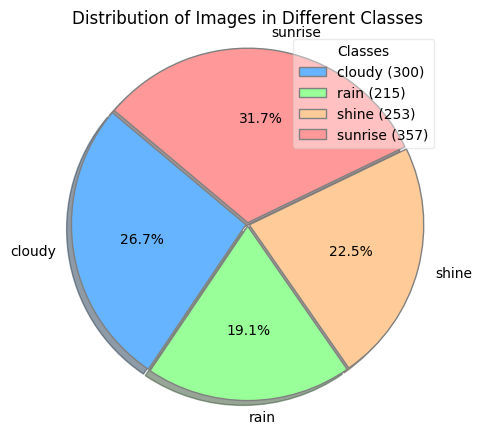

In [40]:
colors = ['#66b3ff', '#99ff99', '#ffcc99', '#ff9999']
explode = (0.01, 0.01, 0.01, 0.01)

plt.figure(figsize=(5, 5))
wedges, texts, autotexts = plt.pie(image_counts, labels=class_labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode, shadow=True, wedgeprops={'edgecolor': 'gray'})
plt.axis('equal')
plt.title('Distribution of Images in Different Classes')

for text, autotext in zip(texts, autotexts):
    angle = (autotext.get_position()[1] + text.get_position()[1]) / 2
    x = 0.5 * np.cos(np.deg2rad(angle))
    y = 0.5 * np.sin(np.deg2rad(angle))

legend_labels = [f"{label} ({count})" for label, count in zip(class_labels, image_counts)]
plt.legend(title="Classes", labels=legend_labels, loc="upper right", framealpha=0.4)

plt.show()


In [17]:
X = []
y = []

for i, label in enumerate(class_labels):
    for j in tqdm(range(1, image_counts[i] + 1), desc=label, unit="image"):
        img_path_jpg = os.path.join(data_dir, f"{label}{j}.jpg")
        img_path_jpeg = os.path.join(data_dir, f"{label}{j}.jpeg")

        if os.path.exists(img_path_jpg):
            img_path = img_path_jpg
        elif os.path.exists(img_path_jpeg):
            img_path = img_path_jpeg
        else:
            continue

        img = io.imread(img_path)

        img_resized = transform.resize(img, image_size)

        if img_resized.shape[-1] == 4:
            img_resized = img_resized[:, :, :3]
        elif len(img_resized.shape) == 2:
            img_resized = color.gray2rgb(img_resized)

        X.append(img_resized.flatten())
        y.append(label)


sunrise: 100%|██████████| 357/357 [04:24<00:00,  1.35image/s]


In [18]:
X = np.array(X)
y = np.array(y)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, stratify=y, random_state=42)

train_label_counts = Counter(y_train)
test_label_counts = Counter(y_test)

print("Training Set Class Counts:")
for label, count in train_label_counts.items():
    print(f"{label}: {count}")

print("\nTesting Set Class Counts:")
for label, count in test_label_counts.items():
    print(f"{label}: {count}")

total_train_images = len(y_train)
total_test_images = len(y_test)

print("\nTotal Images for Training:", total_train_images)
print("Total Images for Testing:", total_test_images)

Training Set Class Counts:
sunrise: 267
rain: 161
cloudy: 225
shine: 190

Testing Set Class Counts:
sunrise: 90
cloudy: 75
shine: 63
rain: 54

Total Images for Training: 843
Total Images for Testing: 282


In [21]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_probs_rf = rf_model.predict_proba(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf, average='weighted')
recall = recall_score(y_test, y_pred_rf, average='weighted')
f1 = f1_score(y_test, y_pred_rf, average='weighted')

print("Accuracy:", accuracy_rf)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.8581560283687943
Precision: 0.8613531518298135
Recall: 0.8581560283687943
F1-Score: 0.8590150430243516


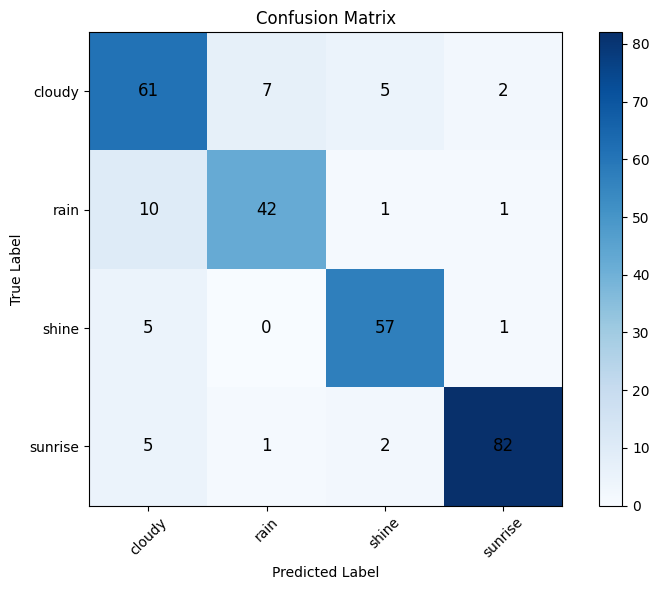

In [22]:
conf_matrix = confusion_matrix(y_test, y_pred_rf, labels=class_labels)

plt.figure(figsize=(8, 6))
plt.title("Confusion Matrix")
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black', fontsize=12)

plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

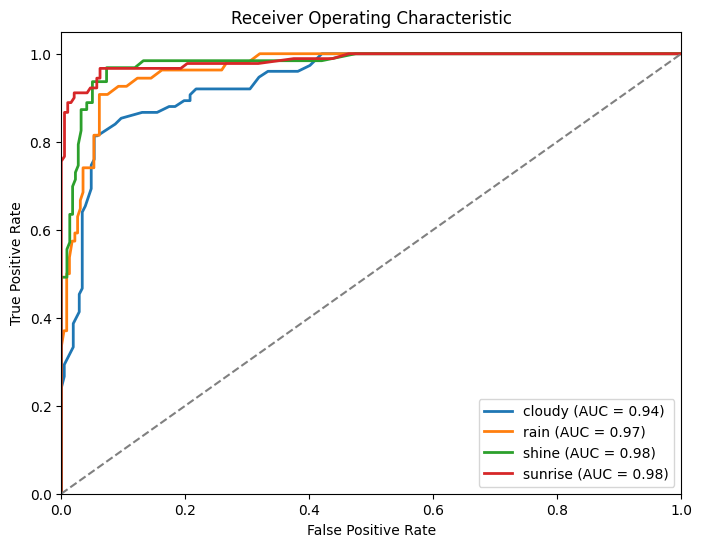

In [23]:
plt.figure(figsize=(8, 6))
for i, label in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(y_test == label, y_probs_rf[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
